## **What Makes People in a Country Happy?**

Lucie Sullivan and Jinkyu Kang


In [ ]:
#Imports used
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Used to upload the csv files from my computer to the notebook
uploaded = files.upload()

In [ ]:
#Read in the files as dataframes
happy15 = pd.read_csv('2015.csv')
happy16 = pd.read_csv('2016.csv')
happy17 = pd.read_csv('2017.csv')
happy18 = pd.read_csv('2018.csv')
happy19 = pd.read_csv('2019.csv')

**Exploratory Data Analysis**

First, each file did not contain a year column. This needed to be added so when merged it is possible to tell each year's data apart. Next, I noticed that some of the years had columns that were not present in other years, these needed to be removed. Finally, the columns that were in all the years often had slightly different names. These needed to be renamed in order for the data to be merged. 

In [ ]:
#Add that year column
happy15['Year'] = 2015
happy16['Year'] = 2016
happy17['Year'] = 2017
happy18['Year'] = 2018
happy19['Year'] = 2019

In [ ]:
#Compare the columns titles of each year
print(happy15.columns)
print(happy16.columns)
print(happy17.columns)
print(happy18.columns)
print(happy19.columns)

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual', 'Year'],
      dtype='object')
Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Lower Confidence Interval', 'Upper Confidence Interval',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual', 'Year'],
      dtype='object')
Index(['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high',
       'Whisker.low', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual', 'Year'],
      dtype='object')
Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life 

In [ ]:
#Remove the unneeded columns
happy15 = happy15.drop(['Region', 'Standard Error', 'Family', 'Trust (Government Corruption)', 'Dystopia Residual'], axis = 1)
happy16 = happy16.drop(['Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Family', 'Trust (Government Corruption)','Dystopia Residual'], axis = 1)
happy17 = happy17.drop(['Whisker.high','Whisker.low','Trust..Government.Corruption.', 'Dystopia.Residual', 'Family'], axis = 1)
happy18 = happy18.drop(['Social support', 'Perceptions of corruption'], axis = 1)
happy19 = happy19.drop(['Social support', 'Perceptions of corruption' ], axis = 1)

In [ ]:
#Rename the columns
happy15.rename(columns= {'Happiness Rank':'Rank', 'Happiness Score':'Score', 'Economy (GDP per Capita)':'GDP', 'Health (Life Expectancy)':'Health'} , inplace = True)
happy16.rename(columns= {'Happiness Rank':'Rank', 'Happiness Score':'Score', 'Economy (GDP per Capita)':'GDP', 'Health (Life Expectancy)':'Health'} , inplace = True)
happy17.rename(columns= {'Happiness.Rank':'Rank', 'Happiness.Score': 'Score', 'Economy..GDP.per.Capita.':'GDP', 'Health..Life.Expectancy.':'Health'}, inplace = True)
happy18.rename(columns= {'Overall rank':'Rank', 'Country or region':'Country', 'GDP per capita':'GDP', 'Healthy life expectancy':'Health', 'Freedom to make life choices':'Freedom'}, inplace = True)
happy19.rename(columns= {'Overall rank':'Rank', 'Country or region':'Country', 'GDP per capita':'GDP', 'Healthy life expectancy':'Health', 'Freedom to make life choices':'Freedom'}, inplace = True )

Luckily, all the data other than the country names are numerical. This will make analysis later easier. To avoid any issues, the country name, along with the year, will be made part of the index. 

In [ ]:
#Set the index of the data to be the year and country
happy15 = happy15.set_index(['Year', 'Country'])
happy16 = happy16.set_index(['Year', 'Country'])
happy17 = happy17.set_index(['Year', 'Country'])
happy18 = happy18.set_index(['Year', 'Country'])
happy19 = happy19.set_index(['Year', 'Country'])

Now that the the years are all comparable, they can finally be merged. Since 2019 is the test set it will not be added here. Though I will still clean it just in case. 

In [ ]:
#Put the training sets together
happyall = happy15.append([happy16, happy17, happy18])

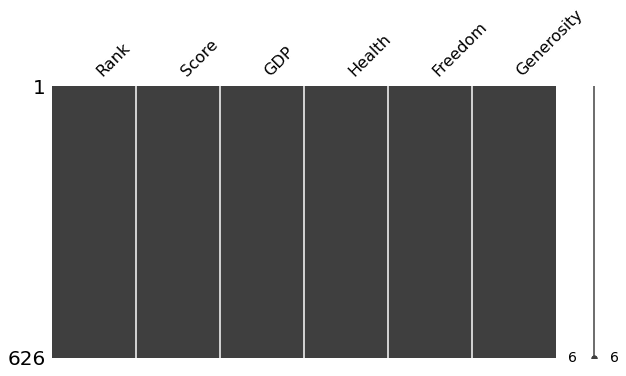

In [ ]:
#Determine if there are any missing values in the training set
missingno.matrix(happyall, figsize = (10,5))

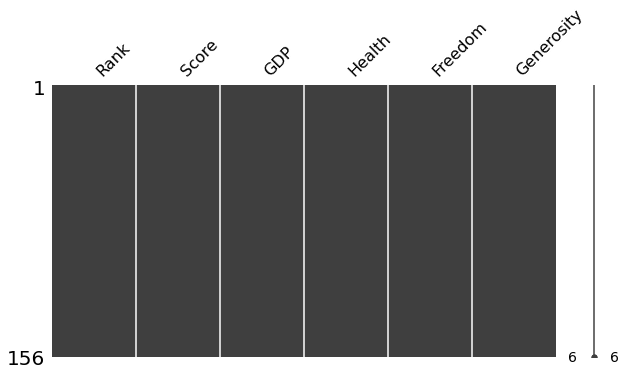

In [ ]:
#Determine if there is any missing data in the test data
missingno.matrix(happy19, figsize = (10, 5))

These plots show that there is not any missing data in the data frames. This means there is no need for removing blank rows or for imputation. 

In [ ]:
happyall.describe()

,Rank,Score,GDP,Health,Freedom,Generosity
count,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000
mean,78.747604,5.372021,0.918764,0.584299,0.415706,0.226981
std,45.219609,1.131774,0.409808,0.241948,0.154943,0.126854
min,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,4.497750,0.606755,0.404142,0.310500,0.137263
50%,79.000000,5.307000,0.983705,0.632553,0.434635,0.208581
75%,118.000000,6.187250,1.239502,0.772957,0.538998,0.290915
max,158.000000,7.632000,2.096000,1.030000,0.724000,0.838075


I used the concept that a value more than 5 standard deviations away from the mean is considered an outlier.

In [ ]:
def out(mean, std, variable):
  outlier1 = mean - std*5
  outlier2 = mean + std*5
  print('The outliers bounds for', variable, 'are:', outlier1, outlier2)

In [ ]:
out(happyall['Score'].mean(), np.std(happyall['Score']), 'Score')
out(happyall['GDP'].mean(), np.std(happyall['GDP']), 'GDP')
out(happyall['Health'].mean(), np.std(happyall['Health']), 'Health')
out(happyall['Freedom'].mean(), np.std(happyall['Freedom']), 'Freedom')
out(happyall['Generosity'].mean(), np.std(happyall['Generosity']), 'Generosity')

The outliers bounds for Score are: -0.2823276236363981 11.02636915764585
The outliers bounds for GDP are: -1.1286410938288254 2.966168669872544
The outliers bounds for Health are: -0.6244741262085106 1.793071510569245
The outliers bounds for Freedom are: -0.3583897616527925 1.1898019846337842
The outliers bounds for Generosity are: -0.40678376683541706 0.8607464125241358


Using my outlier model, there are no categories with outlier data. This means the data does not need to be further cleaned.  

In [ ]:
print('The average happiness score in 2015 was:', happyall.loc[2015]['Score'].mean())
print('The average happiness score in 2016 was:', happyall.loc[2016]['Score'].mean())
print('The average happiness score in 2017 was:', happyall.loc[2017]['Score'].mean())
print('The average happiness score in 2018 was:', happyall.loc[2018]['Score'].mean())
print('The average happiness score over time was:', happyall['Score'].mean())

The average happiness score in 2015 was: 5.3757341772151905
The average happiness score in 2016 was: 5.382184713375795
The average happiness score in 2017 was: 5.354019355773926
The average happiness score in 2018 was: 5.375916666666668
The average happiness score over time was: 5.3720207670047255


In [ ]:
print('The median happiness score in 2015 was:', happyall.loc[2015]['Score'].median())
print('The median happiness score in 2016 was:', happyall.loc[2016]['Score'].median())
print('The median happiness score in 2017 was:', happyall.loc[2017]['Score'].median())
print('The median happiness score in 2018 was:', happyall.loc[2018]['Score'].median())
print('The median happiness score over time was:', happyall['Score'].median())

The median happiness score in 2015 was: 5.2325
The median happiness score in 2016 was: 5.314
The median happiness score in 2017 was: 5.27899980545044
The median happiness score in 2018 was: 5.378
The median happiness score over time was: 5.306999935150145


The average happiness score did not change very much over the five years recoreded here. The range is only aproximately 0.03. The median has a slightly larger range of 0.15. This shows that the happiness scores do shift a little bit over the years but not significantly. 

In [ ]:
#Calculate the Spearman Rank Correlation Coefficients between each variable
spearman_corr =  happyall.corr(method='spearman')
spearman_corr

,Rank,Score,GDP,Health,Freedom,Generosity
Rank,1.000000,-0.998882,-0.805794,-0.768613,-0.542690,-0.136587
Score,-0.998882,1.000000,0.804404,0.770034,0.542388,0.138225
GDP,-0.805794,0.804404,1.000000,0.815036,0.357481,0.009884
Health,-0.768613,0.770034,0.815036,1.000000,0.380487,0.059073
Freedom,-0.542690,0.542388,0.357481,0.380487,1.000000,0.327990
Generosity,-0.136587,0.138225,0.009884,0.059073,0.327990,1.000000


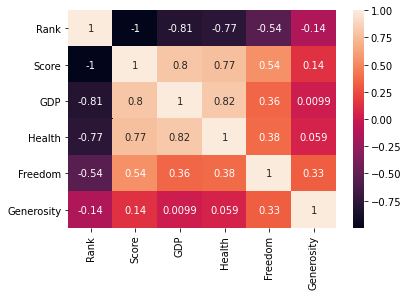

In [ ]:
#Create a heat map to help visualize the relationships
sns.heatmap(spearman_corr, annot = True)

I calculated the spearman correlation matrix. I chose this method of correlation because the final happiness score is ranked, which leads me to believe the rank of the other scores is valuable as well. It makes sense that the correlations between any variable and its score/rank are negatives of eachother. This is because as score becomes a higher number the rank should get lower. The most important correlations to study here is the relationship between each variable and its happiness score. Based on this, GDP and Health have the two highest correlations. This leads me to believe that these two variables contribute the most to the overall happiness score. 

Next, I will visualize the relationship between happiness scores and some of the other variables. These will be used to confirm the data collected from the correlation matrix. 

Text(0.5, 1.0, 'Happiness Score vs. GDP')

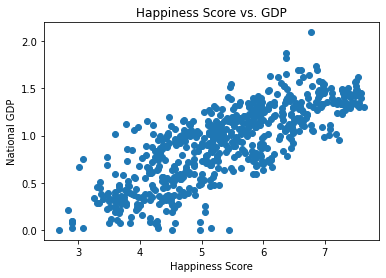

In [ ]:
plt.scatter(happyall['Score'], happyall['GDP'])
plt.xlabel('Happiness Score')
plt.ylabel('National GDP')
plt.title('Happiness Score vs. GDP')

This plot shows the relatively high positive correlation between a country's happiness score and its GDP. This confirms that a higher GDP tends to mean greater happiness. 

Text(0.5, 1.0, 'Happiness Score vs. Health')

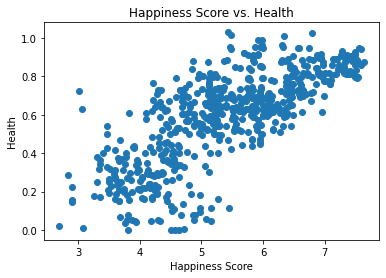

In [ ]:
plt.scatter(happyall['Score'], happyall['Health'])
plt.xlabel('Happiness Score')
plt.ylabel('Health')
plt.title('Happiness Score vs. Health')

The data in this plot is a little more spread out than the data in the GDP plot. However, the positive correlation between the two variables is easy to see. 

Text(0.5, 1.0, 'Happiness Score vs. Generosity')

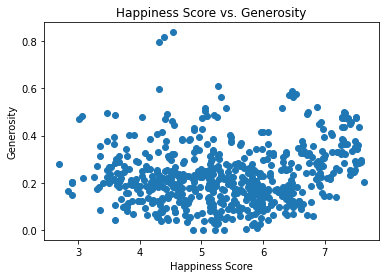

In [ ]:
plt.scatter(happyall['Score'], happyall['Generosity'])
plt.xlabel('Happiness Score')
plt.ylabel('Generosity')
plt.title('Happiness Score vs. Generosity')

This plot is all over the place. There is not a linear relationship between happiness score and generosity. The shape of this graph looks almost quadratic, with the minimum around a score of 5. This may make sense because as shown with past graphs, countries that are less happy have lower GDPs. Therefore they may need to rely on generosity more in order to survive. The happiest countries likely have higher generosity scores because they can afford to help eachother. 

Here, I will look at how the ranks of the top (Switzerland) and bottom (Togo) countries from 2015 change over the years. 

In [ ]:
swi = happyall.loc[2015,'Switzerland', : ]
swi = swi.append(happyall.loc[2016,'Switzerland', : ])
swi = swi.append(happyall.loc[2017,'Switzerland', : ])
swi = swi.append(happyall.loc[2018,'Switzerland', : ])
swi

,,Rank,Score,GDP,Health,Freedom,Generosity
Year,Country,,,,,,
2015,Switzerland,1,7.587,1.39651,0.941430,0.665570,0.296780
2016,Switzerland,2,7.509,1.52733,0.863030,0.585570,0.280830
2017,Switzerland,4,7.494,1.56498,0.858131,0.620071,0.290549
2018,Switzerland,5,7.487,1.42000,0.927000,0.660000,0.256000


Switzerland's rank decreases every year. This may impact the ability to make predictions about happiness rank since its scores are getting worse. 

In [ ]:
togo = happyall.loc[2015,'Togo', : ]
togo = togo.append(happyall.loc[2016,'Togo', : ])
togo = togo.append(happyall.loc[2017,'Togo', : ])
togo = togo.append(happyall.loc[2018,'Togo', : ])
togo

,,Rank,Score,GDP,Health,Freedom,Generosity
Year,Country,,,,,,
2015,Togo,158,2.839,0.208680,0.284430,0.364530,0.166810
2016,Togo,155,3.303,0.281230,0.248110,0.346780,0.175170
2017,Togo,150,3.495,0.305445,0.247106,0.380426,0.196896
2018,Togo,139,3.999,0.259000,0.253000,0.434000,0.158000


Togo's rank improved significantly every year, especially between 2017 and 2018. This is interesting. 

Based on the data collected in this EDA, I think the factors that contribute most to happiness is a country's GDP and its health score. This makes sense to me because in the happier countries, people have the money to support themselves and the health to feel good. If I were the president of a country, I would make citizens happier using these two factors. First of all, I would implement universal health care. This would help people to stay healthy and be able to afford to take care of themselves if they got sick. Not being overcharged for health care would help the GDP! Also, I would do my best to stimulate the economy in order to grow the GDP. 

**Modeling and Question Answering**

Before running any of the machine learning algorithms, the training set and the test set must be split into the variables and the happiness score. I also dropped the rank column because it is basically the same as the happiness score and is not used in the calculation of the score. 

In [ ]:
#Organize the training set
train_variables = happyall.drop(columns = ['Rank', 'Score'])
train_score = happyall.drop(columns = ['GDP', 'Health', 'Freedom', 'Generosity', 'Rank'])

In [ ]:
#Organize the test set
test_variables = happy19.drop(columns = ['Rank', 'Score'])
test_score = happy19.drop(columns = ['GDP', 'Health', 'Freedom', 'Generosity', 'Rank'])

The first model I tested is mulitple linear regression. Mulitple linear regression is a model that summarizes the relationship between a set of independent variables and a dependent variable. This is done by calculating the best fit line by minimizing the sum of squares of the residuals. In order for this model to be accurate, the relationship between the variables must be linear. The coefficients show the direction of the relationship between each independent variable and the dependent variable.

In [ ]:
#Calculate the regression model
regressor = LinearRegression()  
regressor.fit(train_variables, train_score)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Show the coefficients of each variable
coeff_df = pd.DataFrame(regressor.coef_)  
coeff_df = coeff_df.rename(columns={0:'GDP', 1:'Health', 2:'Freedom', 3:'Generosity'})
coeff_df

,GDP,Health,Freedom,Generosity
0,1.349615,1.214187,2.025352,0.542277


In [ ]:
#Show the y intercept
print(regressor.intercept_)

[2.45755707]


According to this model, freedom has the highest impact on overall happiness score. This is surprising to me because during the EDA the correlatoin coefficients implied that GDP and health have the highest impact. The least impactful is generosity. 

In [ ]:
#Calculate the score predictions for 2019 and put them in a DF so the two scores can be compared
LR_pred = regressor.predict(test_variables)
compare = test_score.copy()
compare.insert(1,'Prediction', LR_pred)
print('The actual scores and the predicted scores in 2019')
compare

The actual scores and the predicted scores in 2019


Score  Prediction
Year Country                                    
2019 Finland                   7.769    6.753308
     Denmark                   7.600    6.869068
     Norway                    7.554    7.082214
     Iceland                   7.494    6.954731
     Netherlands               7.488    6.857327
...                              ...         ...
     Rwanda                    3.334    4.929324
     Tanzania                  3.231    4.700094
     Afghanistan               3.203    3.453924
     Central African Republic  3.083    3.203276
     South Sudan               2.853    3.358518

[156 rows x 2 columns]

Based on a preliminary look at the data, the linear regression model does not seem to be super accurate. From here, the mean absolute error, mean square error, and root mean square error are calculated to numerically evaluate the performance of the algorithm. 

In [ ]:
#Calculate values to evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(compare['Score'], compare['Prediction']))  
print('Mean Squared Error:', metrics.mean_squared_error(compare['Score'], compare['Prediction']))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(compare['Score'], compare['Prediction'])))
print('10% of the mean of the predicted values:', compare['Prediction'].mean()*.1)

Mean Absolute Error: 0.4404018385603312
Mean Squared Error: 0.3179461232687731
Root Mean Squared Error: 0.5638671149027695
10% of the mean of the predicted values: 0.5455070737861882


When comparing the root mean squared error to 10% of the mean value, they are about the same. This leads me to believe that the model is not very accurate but can still make relevant predictions. 

In [ ]:
compare = compare.drop(columns=['Score'])
compare = compare.sort_values(by=['Prediction'], ascending = False)
print('The countries ranked by their predicted scores for 2019')
compare

The countries ranked by their predicted scores for 2019


Prediction
Year Country                             
2019 Singapore                   7.237593
     Norway                      7.082214
     Qatar                       7.031238
     Luxembourg                  7.028383
     Switzerland                 6.995644
...                                   ...
     Chad                        3.622829
     Burundi                     3.522049
     Afghanistan                 3.453924
     South Sudan                 3.358518
     Central African Republic    3.203276

[156 rows x 1 columns]

In [ ]:
print('The countries ranked by their actual scores for 2019')
test_score

The countries ranked by their actual scores for 2019


Score
Year Country                        
2019 Finland                   7.769
     Denmark                   7.600
     Norway                    7.554
     Iceland                   7.494
     Netherlands               7.488
...                              ...
     Rwanda                    3.334
     Tanzania                  3.231
     Afghanistan               3.203
     Central African Republic  3.083
     South Sudan               2.853

[156 rows x 1 columns]

As you can see above, the top 5 ranks and the bottom 5 ranks are completely different between the actual data and the predicted data. Hopefully another algorithm will be more accurate. 

The second machine learning algorithm is support vector regression. Support vectors can be used for regression (which is what is done here) or classification. In regression, the algorithm uses the typical linear equation (y=mx+b) but also tries to minimize an error (e). As long as errors are less than e, they do not impact the quality of the solution. Support vector regression allows for nonlinear relationships by representing them as a hyperplane. 

In [ ]:
#Calculate the SVR model
regressor = SVR()
regressor.fit(train_variables, train_score)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#Predict the 2019 happiness scores
SVR_pred = regressor.predict(test_variables)

In [ ]:
#Create a DF to compare the scores
compare2 = test_score.copy()
compare2.insert(1,'Prediction', SVR_pred)
print('The actual scores and the predicted scores in 2019')
compare2

The actual scores and the predicted scores in 2019


Score  Prediction
Year Country                                    
2019 Finland                   7.769    6.693639
     Denmark                   7.600    6.940216
     Norway                    7.554    6.962506
     Iceland                   7.494    7.064675
     Netherlands               7.488    6.974788
...                              ...         ...
     Rwanda                    3.334    4.760182
     Tanzania                  3.231    4.629711
     Afghanistan               3.203    3.710944
     Central African Republic  3.083    3.726608
     South Sudan               2.853    3.578461

[156 rows x 2 columns]

From this, the SVR model does not seem to be super accurate. From here, the mean absolute error, mean square error, and root mean square error are calculated to numerically evaluate the performance of the algorithm. 

In [ ]:
#Calculate values to evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(compare2['Score'], compare2['Prediction']))  
print('Mean Squared Error:', metrics.mean_squared_error(compare2['Score'], compare2['Prediction']))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(compare2['Score'], compare2['Prediction'])))
print('10% of the mean of the predicted values:', compare2['Prediction'].mean()*.1)

Mean Absolute Error: 0.44257107495452286
Mean Squared Error: 0.3017947799495671
Root Mean Squared Error: 0.549358516771668
10% of the mean of the predicted values: 0.5435310455485708


Again, the mean sqaure value is about 10% of the mean predicted value. This means that this model seems to be about as accurate as the linear regression model. From here the rankings will be compared. 

In [ ]:
compare2 = compare2.drop(columns=['Score'])
compare2 = compare2.sort_values(by=['Prediction'], ascending = False)
print('The countries ranked by their predicted scores for 2019')
compare2

The countries ranked by their predicted scores for 2019


Prediction
Year Country                             
2019 Iceland                     7.064675
     United Arab Emirates        7.038653
     Netherlands                 6.974788
     Norway                      6.962506
     Malta                       6.954921
...                                   ...
     Chad                        3.750688
     Central African Republic    3.726608
     Afghanistan                 3.710944
     Burundi                     3.709792
     South Sudan                 3.578461

[156 rows x 1 columns]

In [ ]:
print('The countries ranked by their actual scores for 2019')
test_score

The countries ranked by their actual scores for 2019


Score
Year Country                        
2019 Finland                   7.769
     Denmark                   7.600
     Norway                    7.554
     Iceland                   7.494
     Netherlands               7.488
...                              ...
     Rwanda                    3.334
     Tanzania                  3.231
     Afghanistan               3.203
     Central African Republic  3.083
     South Sudan               2.853

[156 rows x 1 columns]

Looking at the ranks, it seems like this model is more accurate for the countries with the worst ranks (for example South Sundan is last in both the prediction and the actual). However, in the best ranked countries there is very little overlap between the prediction and actual results. 

The third and final machine learning algorithm used is random forest. Random forest is based on the concept of decision trees. The algorithm builds a large number of trees (which is why it's called a forest) based on the different attributes in the data. From here, the algorithm takes the average result made by the forest as the final decision. This process works for both regression and classification! 

In [ ]:
#Calculate the RFR model
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)
regressor.fit(train_variables, train_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
#Determine which feaatures contribute most to this model
features = pd.DataFrame(regressor.feature_importances_)  
features = features.rename(columns={0:'Importance Value'})
features.insert(column = 'Categories', value = ['GDP', 'Health', 'Freedom', 'Generosity'], loc = 1)
features

,Importance Value,Categories
0,0.432924,GDP
1,0.355963,Health
2,0.145214,Freedom
3,0.065899,Generosity


This shows that based on this model the most important feature is the country's GDP and generosity is the least important. This aligns with the predictions made during the EDA. 

In [ ]:
#Calculate the score predictions for 2019 and put them in a DF so the two scores can be compared
RFR_pred = regressor.predict(test_variables)

In [ ]:
#Create a DF to compare the scores
compare3 = test_score.copy()
compare3.insert(1,'Prediction', SVR_pred)
print('The actual scores and the predicted scores in 2019')
compare3

The actual scores and the predicted scores in 2019


Score  Prediction
Year Country                                    
2019 Finland                   7.769    6.693639
     Denmark                   7.600    6.940216
     Norway                    7.554    6.962506
     Iceland                   7.494    7.064675
     Netherlands               7.488    6.974788
...                              ...         ...
     Rwanda                    3.334    4.760182
     Tanzania                  3.231    4.629711
     Afghanistan               3.203    3.710944
     Central African Republic  3.083    3.726608
     South Sudan               2.853    3.578461

[156 rows x 2 columns]

From this, the random forest model does not seem to be super accurate. From here, the mean absolute error, mean square error, and root mean square error are calculated to numerically evaluate the performance of the algorithm. 

In [ ]:
#Calculate values to evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(compare3['Score'], compare3['Prediction']))  
print('Mean Squared Error:', metrics.mean_squared_error(compare3['Score'], compare3['Prediction']))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(compare3['Score'], compare3['Prediction'])))
print('10% of the mean of the predicted values:', compare3['Prediction'].mean()*.1)

Mean Absolute Error: 0.44257107495452286
Mean Squared Error: 0.3017947799495671
Root Mean Squared Error: 0.549358516771668
10% of the mean of the predicted values: 0.5435310455485708


Based on the data, the error isn't substantial. However, it still leads me to believe that this model is about as accurate as the first two. 

In [ ]:
#Creates a df to show the ranks based on the prediction
compare3 = compare3.drop(columns=['Score'])
compare3 = compare3.sort_values(by=['Prediction'], ascending = False)
print('The countries ranked by their predicted scores for 2019')
compare2

The countries ranked by their predicted scores for 2019


Prediction
Year Country                             
2019 Iceland                     7.064675
     United Arab Emirates        7.038653
     Netherlands                 6.974788
     Norway                      6.962506
     Malta                       6.954921
...                                   ...
     Chad                        3.750688
     Central African Republic    3.726608
     Afghanistan                 3.710944
     Burundi                     3.709792
     South Sudan                 3.578461

[156 rows x 1 columns]

In [ ]:
#prints a dataframe of the actual rankings
print('The countries ranked by their actual scores for 2019')
test_score

The countries ranked by their actual scores for 2019


Score
Year Country                        
2019 Finland                   7.769
     Denmark                   7.600
     Norway                    7.554
     Iceland                   7.494
     Netherlands               7.488
...                              ...
     Rwanda                    3.334
     Tanzania                  3.231
     Afghanistan               3.203
     Central African Republic  3.083
     South Sudan               2.853

[156 rows x 1 columns]

Just like with the other models in this project, the predicted ranks do not match the actual ranks. Also again, the bottom 5 have more in common between actual/predicted than the top 5. 

Based on the EDA and the models, the most important factor going into the happiness score is the GDP. Another interesting thing I noticed is that the only country that is consistently calculated as in the top 5 happiest countries is Norway, regardless of the model used. 

If I were in charge of the World Happiness Report, I would base the happiness score on the following: GDP and availability of health care.

If I had to create a formula for happiness score, I would use the coefficients from the linear regression model: 

            s=2.46+1.35x+1.21y+2.03z+0.54w

where x = GDP, y = health, z = freedom, and w = generosity.